In [1]:
import numpy as np
from pathlib import Path
import os
from matplotlib import pyplot as plt
import geopandas as gpd
import contextily as cx
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from telenvi import vector_tools as vt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

- Download and explore dataset

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
x, y = mnist["data"], mnist["target"]
print(type(x), type(y))
print(x.shape, y.shape)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(70000, 784) (70000,)


In [4]:
x_ar = np.array(x)
y_ar = np.array(y)
print(x_ar.shape, y_ar.shape)

(70000, 784) (70000,)


The 10th instance is labelled as 3
The 382th feature in this instance represent a pixel with a value of 146. 
It is located in (18, 13) in the 2d space.


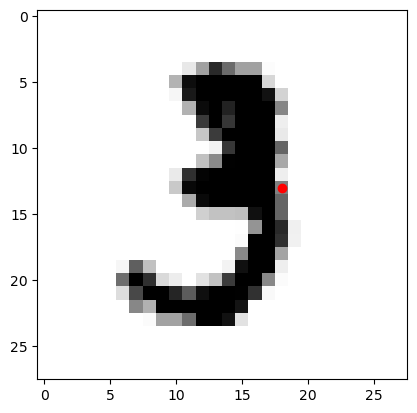

In [5]:
# Define a test index for an instance
test_instance_index = 10

# Define indexes for a feature (a pixel)
feature_column_index, feature_row_index = 18, 13

# Catch image dimensions
height = width = np.sqrt(len(x_ar[test_instance_index])).astype('int8')

# Reshape in 2D format
test_instance = x_ar[test_instance_index].reshape((height, width))

# Display as an image
ax = plt.imshow(test_instance, cmap='Greys')

plt.scatter(feature_column_index, feature_row_index, c='red')

# Display the instance label
print(f"The {test_instance_index}th instance is labelled as {y[test_instance_index]}")

# Display a feature value
print(f"The {feature_row_index * 28 + feature_column_index}th feature in this instance represent a pixel with a value of {test_instance[feature_row_index][feature_column_index]}. \nIt is located in {(feature_column_index, feature_row_index)} in the 2d space.")

In [6]:
def show_instance(ds, index, cmap='Greys', figsize=(4,4), height=28, width=28):
    instance_to_show = ds[index].reshape(height, width)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(instance_to_show, cmap=cmap)
    return ax

In [7]:
type(y_ar[0])

str

In [8]:
y_ar = y_ar.astype('int8')
type(y_ar[0])

numpy.int8

In [9]:
len(x_ar)

70000

- Divide the dataset in train / test set

In [10]:
# help(train_test_split)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_ar, y_ar, test_size=0.2, random_state=1)

Associated label = 4


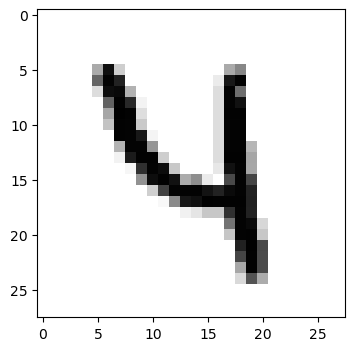

In [12]:
index = 5
show_instance(x_train, index)
print(f"Associated label = {y_train[index]}")

- Binary classifier

In [26]:
from sklearn.linear_model import SGDClassifier

# Define the target digit. 
# Our model will only be capable to detect if 
# a given instance represent this digit or not
digit_to_detect = 5

# Transform the labels by True or False
y_train_equals_to_digit_to_detect = (y_train == digit_to_detect)

# y_train_t[foo] == True --> x_train[foo] represent a digit equal to digit_to_detect
# y_train_t[foo] == False--> x_train[foo] represent another digit


In [27]:
# Create a SGD classifier instance 
sgd_clf = SGDClassifier(random_state=1)

# Use its .fit method to train it
_ = sgd_clf.fit(
    X = x_train, # The instances 
    y = y_train_equals_to_digit_to_detect # The associated labels : True or False)
)

Text(0.5, 0.98, 'SGD Classifier predictions | Digit 5')

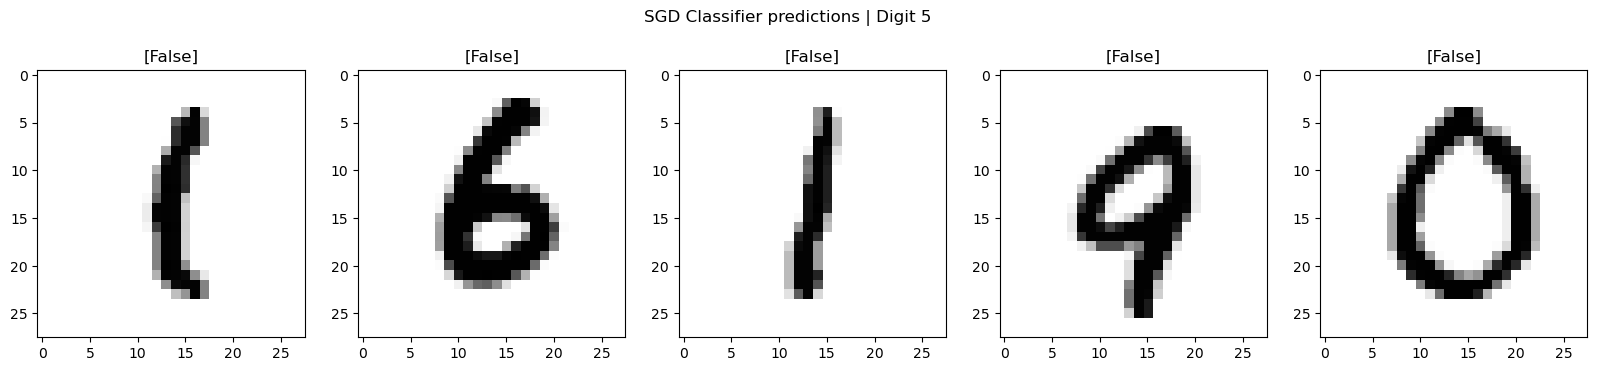

In [28]:
import random

def instance_show_digit(instance):
    """
    Apply the binary classifier on an instance located in x_train
    to the index_to_investigate position
    """

    # The model analyze this instance to see if it's or not equal to the digit
    return sgd_clf.predict([instance])

# Test with different digits
num_tests = 5
fig, axes = plt.subplots(1, num_tests, figsize=(20, 4))
for i in range(0, num_tests):

    # Choose an instance randomly in the x_test set
    random_instance = random.choice(x_test)

    # Display the instance analyzed
    axes[i].imshow(random_instance.reshape((28,28)), cmap='Greys')

    # Analyze it with the model
    res = instance_show_digit(random_instance)

    # Show the result
    axes[i].set_title(str(res))

fig.suptitle(f"SGD Classifier predictions | Digit {digit_to_detect}")

- cross validation to measure performance

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
help(StratifiedKFold)

Help on class StratifiedKFold in module sklearn.model_selection._split:

class StratifiedKFold(_BaseKFold)
 |  StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None)
 |  
 |  Stratified K-Fold cross-validator.
 |  
 |  Provides train/test indices to split data in train/test sets.
 |  
 |  This cross-validation object is a variation of KFold that returns
 |  stratified folds. The folds are made by preserving the percentage of
 |  samples for each class.
 |  
 |  Read more in the :ref:`User Guide <stratified_k_fold>`.
 |  
 |  For visualisation of cross-validation behaviour and
 |  comparison between common scikit-learn split methods
 |  refer to :ref:`sphx_glr_auto_examples_model_selection_plot_cv_indices.py`
 |  
 |  Parameters
 |  ----------
 |  n_splits : int, default=5
 |      Number of folds. Must be at least 2.
 |  
 |      .. versionchanged:: 0.22
 |          ``n_splits`` default value changed from 3 to 5.
 |  
 |  shuffle : bool, default=False
 |      Whether to shuffl

In [30]:
skfolds = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
type(skfolds)

sklearn.model_selection._split.StratifiedKFold

In [31]:
k = skfolds.split(x_train, y_train_equals_to_digit_to_detect)

In [32]:
kl = [n for n in k]

--> En fait, le train set a été séparé en prenant garde à ce que la même proportion de chaque classe soit respectée dans chaque "feuille". 
--> Dans le résultat de la méthode split, on a :
un générateur
    - contenant un nombre d'objets == à n_splits
        - chaque objet est un tuple ou une fold
            - contenant deux matrices
                - une array avec les indexes du train set sélectionnés pour cette fold
                - une array avec les indexes du test set

In [33]:
kl[3]

(array([    1,     2,     4, ..., 55997, 55998, 55999]),
 array([    0,     3,     7, ..., 55987, 55992, 55993]))

In [34]:
for train_index, test_index in skfolds.split(x_train, y_train_equals_to_digit_to_detect):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_equals_to_digit_to_detect[train_index]
    X_test_fold = x_train[test_index]
    y_test_fold = y_train_equals_to_digit_to_detect[test_index]
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.955
0.9618571428571429
0.9591428571428572
0.9672857142857143


In [35]:
# This cell is making exactly the same operation than the cells before
# We just impletemented it more in-depth to see how it works. 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy')

array([0.86328816, 0.85964536, 0.88171006])

- Notons toutefois la différence de temps de traitement ! La solution où on boucle sur les K-Folds manuellement fonctionne 3.5 plus rapidement que la fonction cross_val_score. Je ne sais pas pourquoi. 

- Le accuracy score n'est pas infaillible. Il est conseillé de travailler avec une confusion matrix

In [36]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_equals_to_digit_to_detect, cv=3)

- Est-ce que y_train_pred contient le résultat des 3 modèles différents utilisés sur chaque fold ?

In [53]:
y_train_pred.shape == y_train_equals_to_digit_to_detect.shape

True

- Donc à priori, oui. La shape du dataset en sortie est égale à la longueur du dataset complet donné en entré, donc le type d'objet retourné n'est pas une array par fold mais une seule.

In [37]:
cfm = confusion_matrix(y_train_equals_to_digit_to_detect, y_train_pred)
cfm

array([[48257,  2727],
       [  828,  4188]])

In [40]:
r = {'true_negative ':cfm[0,0],'true_positive ':cfm[1,1], 'false_negative':cfm[0,1], 'false_positive':cfm[1,0]}

{'true_negative ': 48257,
 'true_positive ': 4188,
 'false_negative': 2727,
 'false_positive': 828}

- Calcul des scores de précision et de recall

In [38]:
tn, fp = cfm[0]
fn, tp = cfm[1]
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(precision)
print(recall)

0.6056399132321041
0.8349282296650717


- En fait il y a des fonctions faites pour ça. 

In [57]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_equals_to_digit_to_detect, y_train_pred)
recall = recall_score(y_train_equals_to_digit_to_detect, y_train_pred)


print(f"""
Let's supposed the digit to detect is 5. 
    - When the model analyze an image and say "This is a {digit_to_detect}", he is correct on {int(precision*100)}% of the cases. (precision)
    - Also, on all its predictions, {int(recall*100)}% of the {digit_to_detect} has been classified as a {digit_to_detect}. Means {100-int(recall*100)}% of the 5 in the dataset are missed.
""")


Let's supposed the digit to detect is 5. 
    - When the model analyze an image and say "This is a 5", he is correct on 60% of the cases. (precision)
    - Also, on all its predictions, 83% of the 5 has been classified as a 5. Means 17% of the 5 in the dataset are missed.



- Here we have a more complete overview of the quality of our model !